<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Decision Trees and Ensemble methods

---

## What is a Random Forest?

---

Random Forests are some of the most widespread classifiers used. They are relatively simple to use because they require very few parameters to set and they perform well. As we have seen, Decision Trees are very powerful machine learning models.

Decision Trees have some critical limitations. In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets. Bagging helps mitigate this problem by exposing different trees to different sub-samples of the whole training set.

Random forests are a further way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance. This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.

### Feature bagging

Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features. This process is sometimes called feature bagging. 

The reason for doing this is due to correlation of trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be selected in many of the bagging base trees, causing them to become correlated. By selecting a random subset of the features at each split, we avoid this correlation between base trees, strengthening the overall model.

#### For a problem with p features, it is typical to use:
- $p^{1/2}$ (rounded down) features in each split for a classification problem.
- $p/3$ (rounded down) with a minimum node size of 5 as the default for a regression problem.


#### Sklearn implementation
- [Sklearn Random Forest Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
- [Sklearn Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

### 1. Load the Boston housing data set

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()
print((boston.data.shape))

(506, 13)


In [4]:
list(boston.keys())

['data', 'target', 'feature_names', 'DESCR', 'filename']

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
X = pd.DataFrame(boston['data'],columns=boston.feature_names)
y = pd.Series(boston.target,name='MEDV')

In [7]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [8]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


### 2. Split into train and test sets and rescale the data with the standard scaler 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=42 )
X_test.shape

(253, 13)

standard scaler after the split 

In [76]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [77]:
X_train

array([[ 0.35949608, -0.51555608,  0.98572244, ...,  0.84599119,
        -0.54400037,  1.62849278],
       [-0.41366745,  2.42360314, -1.26202295, ..., -1.57451805,
         0.1829827 , -1.10236752],
       [-0.41389802, -0.51555608,  0.39331539, ..., -1.03662711,
         0.40766928, -0.72856691],
       ...,
       [-0.41862056,  2.84348303, -1.29461951, ..., -0.58838466,
         0.38749291, -0.92604648],
       [ 0.94109469, -0.51555608,  0.98572244, ...,  0.84599119,
        -2.58181356,  1.51141561],
       [-0.39254349, -0.51555608, -0.36632618, ...,  1.1597609 ,
        -2.99431994, -0.27154277]])

In [78]:
X_test

array([[-0.40925478, -0.51555608, -1.0055022 , ..., -0.76768164,
         0.43566267, -0.49582313],
       [-0.41356619,  1.16396348, -0.67103315, ..., -0.31943919,
         0.45045163, -1.27304629],
       [-0.40755169, -0.51555608,  2.35194347, ...,  0.80116694,
         0.37872517,  0.77792008],
       ...,
       [-0.39909601, -0.51555608, -0.73480903, ...,  0.39774874,
         0.41379613, -0.34207119],
       [-0.39053541, -0.51555608, -0.17641579, ...,  0.03915478,
         0.45045163,  0.47746902],
       [-0.2008212 , -0.51555608,  1.19547421, ..., -1.6193423 ,
        -1.33785067, -0.05854695]])

### 3. Fit the data using a decision tree regressor on the training data and obtain mean squared and r2 error for the test set for a maximal tree depth of three.

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(max_depth=3)
regressor.fit(X_train,y_train)
#test the score (r2) and mean squred mean in cross validation. 
print(cross_val_score(regressor, X_test,y_test , cv=3).mean())
print(regressor.score(X_test,y_test))

0.6733872267756421
0.6337615003976473


In [80]:
regressor.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

note : Working with Decision Trees in Python:
#Import Library
##### Import other necessary libraries like pandas, numpy…
from sklearn import tree

##### Assumed you have, X (predictor) and Y (target) for training data set and x_test (predictor) of test_dataset
###### Create tree object
model = tree.DecisionTreeClassifier(criterion=’gini’) # for classification, here you can change the algorithm as gini or entropy (information gain) by default it is gini
###### model = tree.DecisionTreeRegressor() for regression
##### Train the model using the training sets and check score
model.fit(X, y)
model.score(X, y)
#Predict Output
predicted = model.predict(x_test)


### 4. Visualise the corresponding decision tree

In [81]:
!pip install GraphViz

In [82]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)

In [83]:
tree.export_graphviz(clf, out_file=None)

'digraph Tree {\nnode [shape=box] ;\n0 [label="X[5] <= 0.924\\nmse = 87.616\\nsamples = 253\\nvalue = 22.749"] ;\n1 [label="X[12] <= 0.26\\nmse = 38.145\\nsamples = 214\\nvalue = 19.888"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="X[5] <= 0.314\\nmse = 22.673\\nsamples = 127\\nvalue = 23.334"] ;\n1 -> 2 ;\n3 [label="X[7] <= -1.215\\nmse = 15.758\\nsamples = 92\\nvalue = 21.632"] ;\n2 -> 3 ;\n4 [label="mse = 0.0\\nsamples = 1\\nvalue = 50.0"] ;\n3 -> 4 ;\n5 [label="X[12] <= -0.686\\nmse = 6.99\\nsamples = 91\\nvalue = 21.32"] ;\n3 -> 5 ;\n6 [label="X[11] <= -0.028\\nmse = 1.731\\nsamples = 15\\nvalue = 23.593"] ;\n5 -> 6 ;\n7 [label="mse = 0.0\\nsamples = 1\\nvalue = 27.0"] ;\n6 -> 7 ;\n8 [label="X[6] <= -1.553\\nmse = 0.967\\nsamples = 14\\nvalue = 23.35"] ;\n6 -> 8 ;\n9 [label="X[2] <= -0.83\\nmse = 0.378\\nsamples = 5\\nvalue = 24.34"] ;\n8 -> 9 ;\n10 [label="X[9] <= -0.509\\nmse = 0.01\\nsamples = 2\\nvalue = 23.6"] ;\n9 -> 10 ;\n11 [label="mse = 0.0

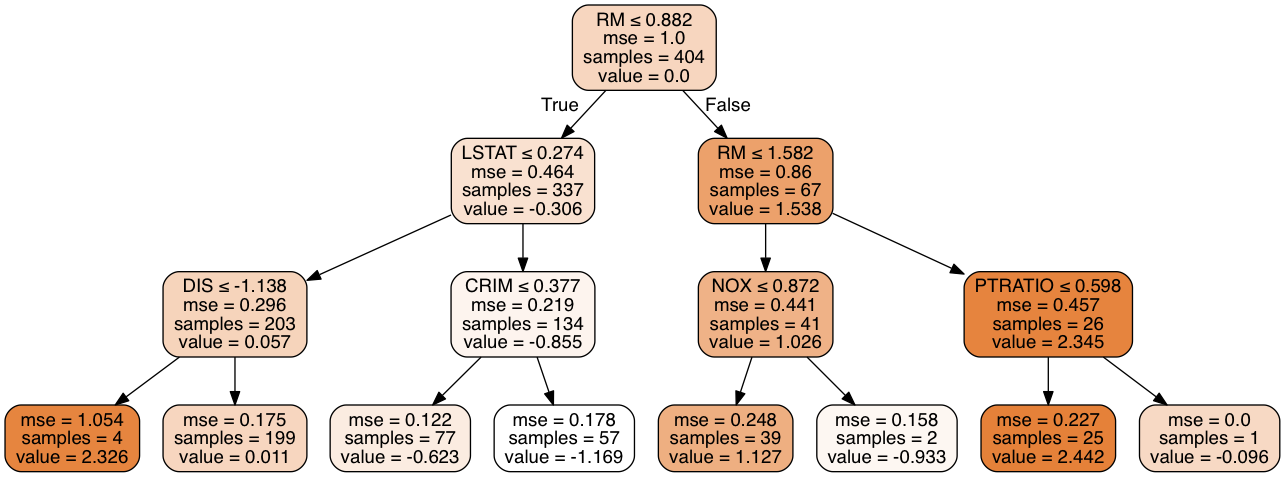

In [84]:
tree.export_graphviz(clf, out_file=None, feature_names=boston.feature_names,
                    class_names=boston.target,filled=True, rounded=True, 
                    special_characters=True)  
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

### 5. Perform grid search varying the maximal tree depth, the maximal number of leaf nodes and the minimal number of samples in the leafs. Determine the best model using once the default R2 scoring and once 'neg_mean_squared_error' and compare.

In [132]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

In [141]:
#standardise your predictor matrices
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [142]:
scoring = r2_score()



TypeError: r2_score() missing 2 required positional arguments: 'y_true' and 'y_pred'

In [179]:
param={'min_samples_split': range(2, 10),
      'max_depth':[1,2,3,4,5,6,6,7,8], 
       'min_samples_leaf': [1,2,3,4,5,6,7,8],
       'max_leaf_nodes': [2,3,4,5,6]}
g_cv = GridSearchCV(DecisionTreeRegressor(),
              param_grid=param,
              cv=5,scoring='r2')
g_cv.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(2, 10), 'max_depth': [1, 2, 3, 4, 5, 6, 6, 7, 8], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8], 'max_leaf_nodes': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [180]:
g_cv.best_estimator_.score(X_train,y_train),g_cv.best_estimator_.score(X_test,y_test)

(0.821191737406025, 0.6952768891135421)

In [177]:
param={'min_samples_split': range(2, 10),
      'max_depth':[1,2,3,4,5,6,6,7,8], 
       'min_samples_leaf': [1,2,3,4,5,6,7,8],
       'max_leaf_nodes': [2,3,4,5,6]}
g_cv = GridSearchCV(DecisionTreeRegressor(),
              param_grid=param,
              cv=5,scoring='neg_mean_squared_error')
g_cv.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(2, 10), 'max_depth': [1, 2, 3, 4, 5, 6, 6, 7, 8], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8], 'max_leaf_nodes': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [178]:
g_cv.best_estimator_.score(X_train,y_train),g_cv.best_estimator_.score(X_test,y_test)

(0.821191737406025, 0.6952768891135421)

In [164]:
#print out your best hyperparameters
g_cv.best_params_

{'max_depth': 5,
 'max_leaf_nodes': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [165]:
md = g_cv.best_estimator_
dir(md)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_estimator_type',
 '_get_param_names',
 '_validate_X_predict',
 'apply',
 'class_weight',
 'classes_',
 'criterion',
 'decision_path',
 'feature_importances_',
 'fit',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_classes_',
 'n_features_',
 'n_outputs_',
 'predict',
 'presort',
 'random_state',
 'score',
 'set_params',
 'splitter',
 'tree_']

In [166]:
#assign your best_estimator_ to the variable, then use .score( ) on your testing data
best_gs = g_cv.best_estimator_
best_gs.score(X_test_ss, y_test)

-6.221549697291552

In [151]:
g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
print(result)
r2_score(y_test, g_cv.best_estimator_.predict(X_test))

{'mean_fit_time': array([0.0012742 , 0.00089936, 0.00086756, ..., 0.00136847, 0.00155745,
       0.00135078]), 'std_fit_time': array([0.00027823, 0.00017466, 0.00012464, ..., 0.00022482, 0.00018299,
       0.00017457]), 'mean_score_time': array([0.00080948, 0.00060449, 0.00046163, ..., 0.00079536, 0.00073304,
       0.00065184]), 'std_score_time': array([2.03569116e-04, 1.93651466e-04, 5.59044340e-05, ...,
       1.56389867e-04, 9.10197829e-05, 1.54023052e-04]), 'param_max_depth': masked_array(data=[2, 2, 2, ..., 8, 8, 8],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'param_max_leaf_nodes': masked_array(data=[2, 2, 2, ..., 6, 6, 6],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[1, 1, 1, ..., 8, 8, 8],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
           

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6952768891135421

In [159]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [181]:
#mean_squared_error(y_test, y_pred)

#neg_mean_squared_error_scorer = make_scorer(mean_squared_error,greater_is_better=False)

### 6. Now use ensemble methods to fit decision trees. For BaggingRegressor and RandomForestRegressor, vary the number of estimators (n_estimators). Use cross_val_score with five-fold cross validation and scoring 'neg_mean_squared_error'. Plot how the mean of the scoring changes.

In [182]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [187]:
dt_en = BaggingRegressor(base_estimator=regressor, n_estimators= 30,
                           max_samples=0.9,
                           max_features=0.5 ,
                           oob_score=True)
dt_en.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.9, n_estimators=30, n_jobs=None, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [188]:
print(dt_en.score(X_train, y_train))

0.8428512244862663


In [189]:
print(dt_en.score(X_test, y_test))

0.7438353146610156


In [190]:
print(dt_en.oob_score_)

0.7383334216296301


In [211]:
from sklearn.ensemble import BaggingRegressor
model1 = BaggingRegressor(tree.DecisionTreeRegressor(random_state=1))
model1.fit(X_train, y_train)
model1.score(X_test,y_test)

0.8054308885013252

In [212]:
print(cross_val_score(model1, X_test,y_test , cv=3).mean())
print(model1.score(X_test,y_test))

0.7436275711594938
0.8054308885013252


In [209]:
from sklearn.ensemble import RandomForestRegressor
model = BaggingRegressor(RandomForestRegressor(random_state=1))
print(model.fit(X_train, y_train))
print(model.score(X_test,y_test))


BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
0.8100747527745212


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

In [210]:
print(cross_val_score(model, X_test,y_test , cv=3).mean())
print(model.score(X_test,y_test))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

0.7577568208541674
0.8100747527745212


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

### Bonus: Vary further parameters and describe the impact on the model score.

Pitfalls of Ensemble learning

In general, it is not true that it will always perform better. There are several ensemble methods, each with its own advantages/weaknesses. Which one to use and then depends on the problem at hand.
For example, if you have models with high variance (they over-fit your data), then you are likely to benefit from using bagging. If you have biased models, it is better to combine them with Boosting. There are also different strategies to form ensembles. The topic is just too broad to cover it in one answer.
But the point is: if you use the wrong ensemble method for your setting, you are not going to do better. For example, using Bagging with a biased model is not going to help.
Also, if you need to work in a probabilistic setting, ensemble methods may not work either. It is known that Boosting (in its most popular forms like AdaBoost) delivers poor probability estimates. That is, if you would like to have a model that allows you to reason about your data, not only classification, you might be better off with a graphical model.
So, in this post, you got introduced to Ensemble learning technique. You covered its basics, how it improves your model's performance. You covered its three main types.
Also, you implemented these three types in Python with the help of scikit-learn, and in this course of action, you gained a bit of knowledge about the necessary preprocessing steps.
That's quite a feat! Well done! In this final section, I suggest some further undertakings on Ensembles which you might want to consider.